In [586]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    precision_score, 
    recall_score,
    classification_report, 
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from xgboost import plot_importance
from catboost import CatBoostClassifier, Pool
import shap
from lime.lime_tabular import LimeTabularExplainer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from scipy import stats
from fairlearn.postprocessing import ThresholdOptimizer  

# 1. Анализ и предобработка данных  

In [640]:
train_data = pd.read_csv('cs-training.csv')

In [641]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

## Обработка пропусков:

Можно заметить, что в колонках MonthlyIncome и NumberOfDependents наблюдаются пропущенные значения, которые нужно обработать. Так как в стобце MonthlyIncome не хватает около 30000 записей, что является пятой частью всего датасета, для предотвращения потери данных я решила заполнить пропуски медианным значением по данной колонке. Пропуски в NumberOfDependents также будут заполнены медианным значением по столбцу.

In [642]:
train_data['MonthlyIncome'] = train_data['MonthlyIncome'].fillna(int(train_data['MonthlyIncome'].median()))
train_data['NumberOfDependents'] = train_data['NumberOfDependents'].fillna(int(train_data['NumberOfDependents'].median()))

## Исследование выбросов:

### - cтолбец age

In [643]:
train_data['age'].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [649]:
def plot_distribution(feature, feature_name, figsize=(5, 3), bins=30, logscale=True):
    Oy_name = 'Frequency'
    plt.figure(figsize=figsize)
    plt.hist(feature, bins=bins)
    if logscale:
        plt.yscale('log')
        Oy_name += '(log scale)'
    plt.xlabel(feature_name)
    plt.ylabel(Oy_name)
    plt.title(f'Histogram of {feature_name}')
    plt.show()

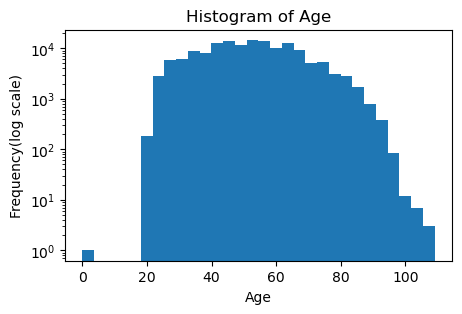

In [650]:
plot_distribution(train_data['age'], 'Age', figsize=(5, 3), bins=30)

Рассмотрим имеющиеся в датасете выбросы. Например, люди возрастом меньше 18 лет, так как они не могут быть заемщиками. В датасете обнаружилась одна такая запись. Заменим age=0 на медианное значение возраста по столбцу.

In [508]:
train_data[train_data['age']<18]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [509]:
mask_18 = (train_data['age'] < 18) 
train_data.loc[mask_18, 'age'] = train_data['age'].median()

Рассмотрим также значения возраста больше 100, чтобы убедиться, что там нет значительных выбросов (например, age>120)

In [510]:
train_data[train_data['age']>100].age

7763      101
19884     103
25561     102
40007     107
56761     105
57967     103
90937     102
93813     101
96450     102
105790    109
116129    101
135025    103
138291    109
Name: age, dtype: int64

In [511]:
train_data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438,52.295553,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.249746,249.755371,14.771249,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Также с помощью метода describe можем проверить, что минимальное значение в каждом столбце >=0. Значит, выбросов в виде отрицательных значений в датаесте нет.

### - cтолбец RevolvingUtilizationOfUnsecuredLines

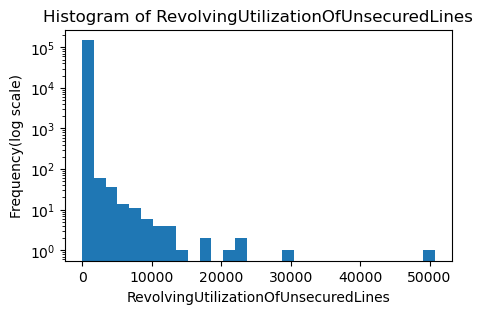

In [651]:
plot_distribution(train_data['RevolvingUtilizationOfUnsecuredLines'], 'RevolvingUtilizationOfUnsecuredLines', figsize=(5, 3), bins=30)

In [513]:
train_data['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

Заметим, что среднее(6.05) значительно выше медианы(0.15), а также максимальное значение(50708) на несколько порядков больше, чем третий квартиль(0.56), что указывает на наличие выбросов в данном столбце. Если говорить о логике заполнения данной колонки, то она отражает "Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и задолженности без рассрочки, например, автокредитов, деленный на сумму кредитных лимитов". То есть по сути отношение текущей задолжности к доступному кредитному лимиту, значение которого >1 возможны, если клиент превысил лимит (например, из-за штрафов или овердрафта). Для того, чтобы определиться, являются ли значения выше 10 выбросами, рассмотрим целевую переменную у данных заемщиков, предполагая, что с аномально высокой долговой нагрузкой должен быть очень высокая вероятность просрочки платежа.

In [514]:
train_data[train_data['RevolvingUtilizationOfUnsecuredLines'] > 10]['SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
0    224
1     17
Name: count, dtype: int64

Наблюдаем, что большинство(93%) заемщиков с RevolvingUtilizationOfUnsecuredLines>10 не являются лицами, просрочившими платеж на 90 дней или больше. А также данные лица (RevolvingUtilizationOfUnsecuredLines>10) составляют всего 0.16%, поэтому смело можем отбросить строки с имеющимися выбросами.

In [515]:
train_data_filtered = train_data[train_data['RevolvingUtilizationOfUnsecuredLines'] <= 10]

### - cтолбец NumberOfTime30-59DaysPastDueNotWorse

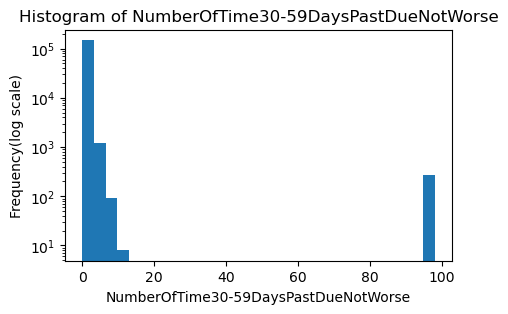

In [652]:
plot_distribution(train_data['NumberOfTime30-59DaysPastDueNotWorse'], 'NumberOfTime30-59DaysPastDueNotWorse', figsize=(5, 3), bins=30)

По логике формировани ястолбца он содержит "Количество раз, когда заемщик просрочил платеж на 30–59 дней за последние 2 года»". Даже если заемщик просрочил каждый платеж за два года, то это значение не будет превышать 24. И учитывая, что большинство ячеек (264 значения == 98) из всех выбросов (269 значений > 24) имеют значение 98, то можем предположить, что эти записи действительно являются выбросами и удалить их из табоицы.

In [517]:
train_data_filtered = train_data_filtered[train_data_filtered['NumberOfTime30-59DaysPastDueNotWorse'] < 24]

### - cтолбец DebtRatio

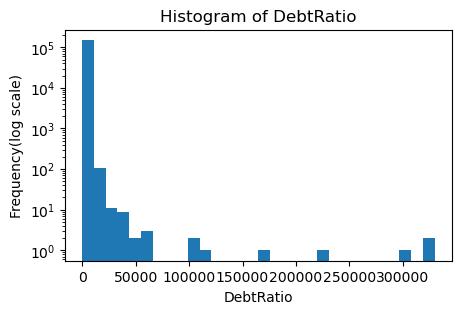

In [653]:
plot_distribution(train_data['DebtRatio'], 'DebtRatio', figsize=(5, 3), bins=30)

Cтолбец, судя по описанию, представляет собой коэффициент долговой нагрузки — отношение ежемесячных обязательных расходов к ежемесячному доходу. Опять же, значения больше 1 говорят, что доходы превышают расходы. При этом можем заметить, что среднее(353.3) сильно превышает медиану(0.37), а максимально значение огромное и явно является выбросом(329664), поэтому данные наблюдения следует удалить из датасета.

In [519]:
print(f"Заемщики с DebtRatio > 2000: {sum(train_data_filtered['DebtRatio']>3000)*100/train_data_filtered['DebtRatio'].shape[0]:.2f}%")

Заемщики с DebtRatio > 2000: 3.50%


КДН уже выше 10 в финансовой аналитике считается ошибкой. Однако, чтобы избежать случайной потери реальных экстремальных значений, выполним обрезку по более мягкой границе DebtRatio = 2000 (всего 3,5% данных). Затем, чтобы снизить влияние сильного разброса значений, проведем логарифмирование значений столбца DebtRatio.

In [520]:
train_data_filtered = train_data_filtered[train_data_filtered['DebtRatio'] <= 3000]
train_data_filtered['DebtRatio'] = np.log1p(train_data_filtered['DebtRatio'])

### - cтолбец NumberOfOpenCreditLinesAndLoans

In [521]:
train_data_filtered['NumberOfOpenCreditLinesAndLoans'].describe()

count    144264.000000
mean          8.376421
std           5.111106
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

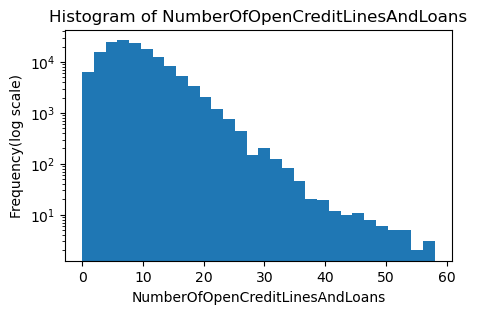

In [655]:
plot_distribution(train_data['NumberOfOpenCreditLinesAndLoans'], 'NumberOfOpenCreditLinesAndLoans')

Содержит информаицю о количестве открытых кредитов (например, автокредит или ипотека) и кредитных линий (например, кредитные карты).
Типичный диапазон (для большинства заёмщиков): 5–11 кредитов/линий (IQR: 25%-75%).
Реалистичным максимумом являются значения в пределе 15-20, поэтому рассмотрим, какой процент заемщиков имеют NumberOfOpenCreditLinesAndLoans > 20:

In [523]:
print(f"Заемщики с NumberOfOpenCreditLinesAndLoans > 20: {sum(train_data_filtered['NumberOfOpenCreditLinesAndLoans']>20)*100/train_data_filtered['DebtRatio'].shape[0]:.2f}%")

Заемщики с NumberOfOpenCreditLinesAndLoans > 20: 2.55%


Сделаем обрезку по значению 20:

In [524]:
train_data_filtered = train_data_filtered[train_data_filtered['NumberOfOpenCreditLinesAndLoans'] <= 20]

### - cтолбец NumberRealEstateLoansOrLines

In [525]:
train_data_filtered['NumberRealEstateLoansOrLines'].describe()

count    140583.000000
mean          0.948457
std           1.016511
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

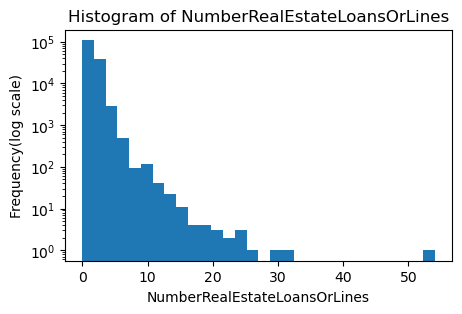

In [656]:
plot_distribution(train_data['NumberRealEstateLoansOrLines'], 'NumberRealEstateLoansOrLines')

В столбце указаны значения количества ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья. Разумным максимумом для данной характеристики является значение - 5. Проверим, сколько % заемщиков имеют более 5 кредитов на недвижимость (предполагаем, что это выбросы).

In [527]:
print(f"Заемщики с более чем пятью кредитами на недвижимость: {sum(train_data_filtered['NumberRealEstateLoansOrLines']>5)*100/train_data_filtered['NumberRealEstateLoansOrLines'].shape[0]:.2f}%")

Заемщики с более чем пятью кредитами на недвижимость: 0.33%


Таким образом, сделаем обрезку значений данного столбца по границе = 5.

In [528]:
train_data_filtered = train_data_filtered[train_data_filtered['NumberRealEstateLoansOrLines'] <= 5]

### - cтолбец NumberRealEstateLoansOrLines

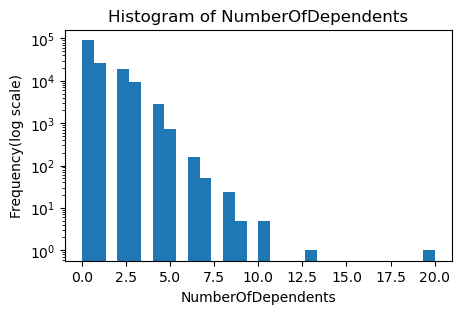

In [657]:
plot_distribution(train_data['NumberOfDependents'], 'NumberOfDependents')

In [530]:
train_data_filtered['NumberOfDependents'].describe()

count    140115.000000
mean          0.745031
std           1.109845
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [531]:
print(f" Заемщики с более чем 10 иждивенцами: {sum(train_data_filtered['NumberOfDependents']>10)*100/train_data_filtered['NumberOfDependents'].shape[0]:.4f}%")

 Заемщики с более чем 10 иждивенцами: 0.0014%


Скорее всего заемщиков с количеством иждивенцов более 10 можно отнести к выбросам в данных.

In [532]:
train_data_filtered = train_data_filtered[train_data_filtered['NumberOfDependents'] <= 10]

Столбцы MonthlyIncome, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse не содержат аномальных значений, можем переходить к следующему шагу анализа.

In [261]:
print(f"Таким образом, после очистки датасета осталось {train_data_filtered.shape[0]} записей")

Таким образом, после очистки датасета осталось 140113 записей


## Анализ корреляции признаков

In [677]:
def createCorrelationHeatMap(data):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(240, 10, n=256, as_cmap=True)
    
    sns.heatmap(corr, annot=True, fmt='.2f', cmap=cmap, center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.5, cbar_kws={'shrink': 0.8}, ax=ax)
    
    ax.set_xticklabels( ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.title('Корреляционная матрица признаков', pad=20, fontsize=14)
    plt.tight_layout()
    plt.savefig('correlation.png')
    plt.show()

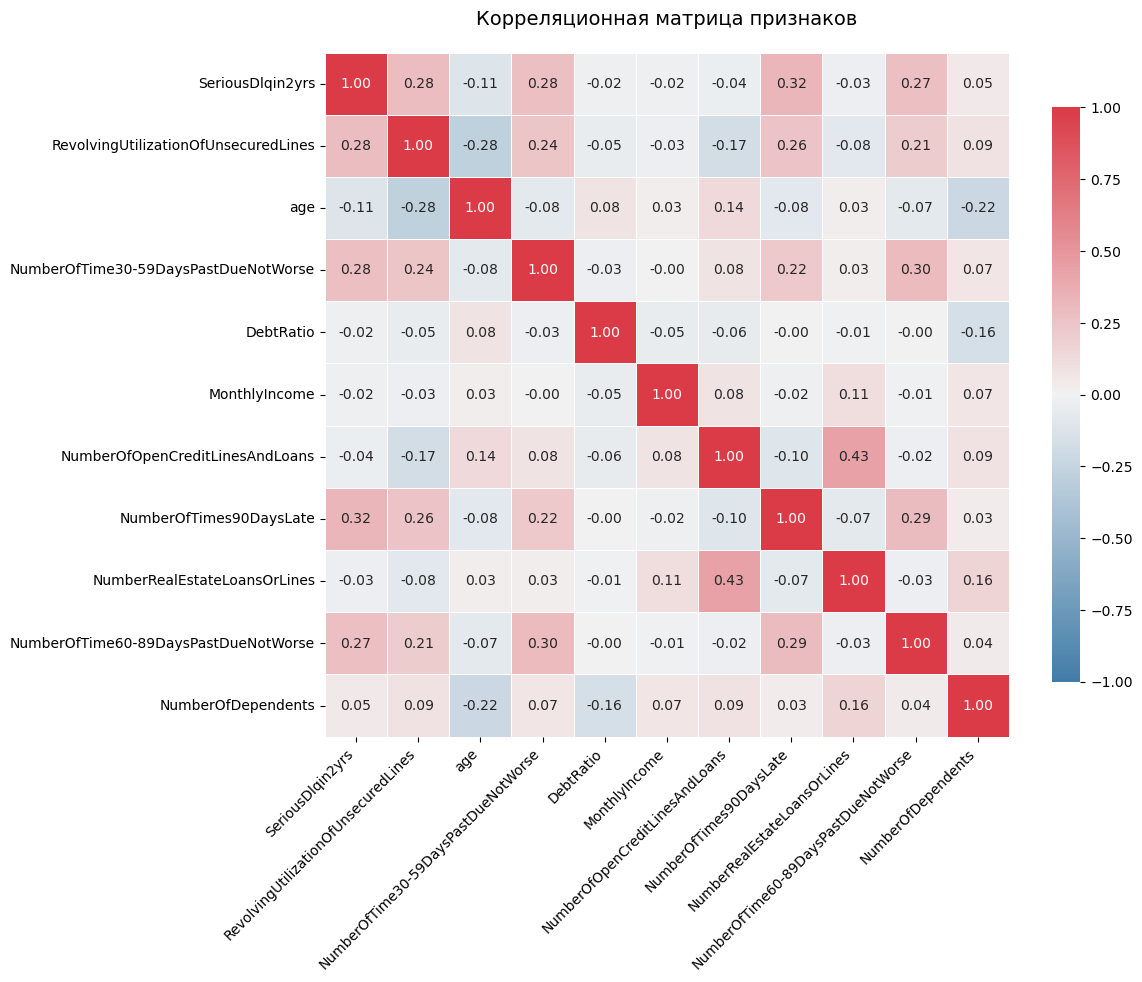

In [678]:
createCorrelationHeatMap(train_data_filtered.iloc[1:,1:])

Самая высокая корреляция наблюдается между признаками NumberOfOpenCreditLinesAndLoans и NumberRealEstateLoansOrLines, так как оба этих показателя отображают открытые ипотечные кредиты (в разных категориях). Однако даже это самое выское значение корреляции = 0.43, что говорит о том, что мультиколлинеарность между признаками не присутствует.

Также можем подметить, что такие признаки как DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines и NumberOfDependents имеют минимальную корреляцию с целевой переменной SeriousDlqin2yrs (<=|0.05|)

## Исследование дисбаланса классов

In [535]:
train_data_filtered['SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
0    130905
1      9208
Name: count, dtype: int64

Датасет является сильно несбалансированным. Примерно 93% заемщиков относятся к 0 классу (нет дефолта) и только у 7% дефолт наблюдался.

Распространенные методы борьбы с дисбалансом классов: 
- Методы взвешивания. Назначение большего веса классу 1 при обучении модели
- Сэмплирование данных. Например, случайно удалить часть данных 0 класса. Или наоборот увеличение клааса 1 (ублировать или синтезировать наблюдения класса 1)
- Бэггинг с BalancedRandomForest, когда каждое дерево строится на сбалансированном подмножестве.

# ---------------------------------------------------------

# 2. Построение и оценка модели

## Разделение данных

Важно отметить, что разбиение датасета на группы следует производить с аттрибутом stratify. Тогда данные будут разделяться стратифицированным образом (по целевой метке)

In [536]:
X = train_data_filtered.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = train_data_filtered['SeriousDlqin2yrs']

# Разделение на train/test (70/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Разделение train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val)

Проведем нормализацию данных с помощью StandardScaler

In [537]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Визуализация данных

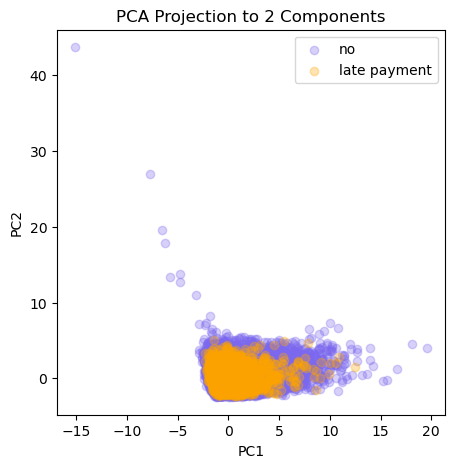

In [636]:
default = train_data_filtered['SeriousDlqin2yrs']

pca = PCA(n_components=5)
df_pca = pca.fit_transform(X_train_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5' ])
df_pca['SeriousDlqin2yrs'] = default

plt.figure(figsize=(5, 5))

plt.scatter(df_pca[df_pca['SeriousDlqin2yrs'] == 0]['PC1'], 
            df_pca[df_pca['SeriousDlqin2yrs'] == 0]['PC2'],
            color='#7B68EE', marker='o', label='no', alpha=0.3)

plt.scatter(df_pca[df_pca['SeriousDlqin2yrs'] == 1]['PC1'], 
            df_pca[df_pca['SeriousDlqin2yrs'] == 1]['PC2'],
            color='orange', marker='o', label='late payment', alpha=0.3)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection to 2 Components')
plt.legend()
plt.savefig('PCA projection')
plt.show()

# Модель логистической регрессии 

### Проведем подбор оптимальных гиперпарматеров с помощью кросс-валидации (5 фолдов)

In [539]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],               
    'solver': ['liblinear', 'saga']       
}

model_lr = LogisticRegression(
    class_weight='balanced',  # учет дисбаланса
    random_state=42,
    max_iter=1000
)

grid_search_lr = GridSearchCV(
    model_lr, 
    param_grid_lr, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

### Отбор лучшей модели

In [540]:
best_model_lr = grid_search_lr.best_estimator_
print(f"Лучшие гиперпараметры: {grid_search_lr.best_params_}")
print(f"Лучший AUC-ROC на валидации: {grid_search_lr.best_score_:.4f}")

Лучшие гиперпараметры: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший AUC-ROC на валидации: 0.8614


### Оценка модели на тестовой выборке

In [541]:
y_test_pred_lr = best_model_lr.predict(X_test_scaled)
y_test_pred_proba_lr = best_model_lr.predict_proba(X_test_scaled)[:, 1]

print("\nОценка на тренировочной выборке:")
print(classification_report(y_train, best_model_lr.predict(X_train_scaled), target_names=['Non-Default', 'Default']))
print(f"\nTrain AUC-ROC: {roc_auc_score(y_train, best_model_lr.predict_proba(X_train_scaled)[:, 1]):.4f}")

print("--------------------------------------------------------")

print("\nОценка на тестовой выборке:\n")
print(classification_report(y_test, y_test_pred, target_names=['Non-Default', 'Default']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")


Оценка на тренировочной выборке:
              precision    recall  f1-score   support

 Non-Default       0.98      0.80      0.88     64143
     Default       0.21      0.76      0.33      4512

    accuracy                           0.80     68655
   macro avg       0.60      0.78      0.61     68655
weighted avg       0.93      0.80      0.85     68655


Train AUC-ROC: 0.8617
--------------------------------------------------------

Оценка на тестовой выборке:

              precision    recall  f1-score   support

 Non-Default       0.96      0.96      0.96     39272
     Default       0.41      0.44      0.42      2762

    accuracy                           0.92     42034
   macro avg       0.69      0.70      0.69     42034
weighted avg       0.92      0.92      0.92     42034

AUC-ROC: 0.8517


In [679]:
def plot_roc_auc(fpr, tpr, roc_auc):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC-ROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

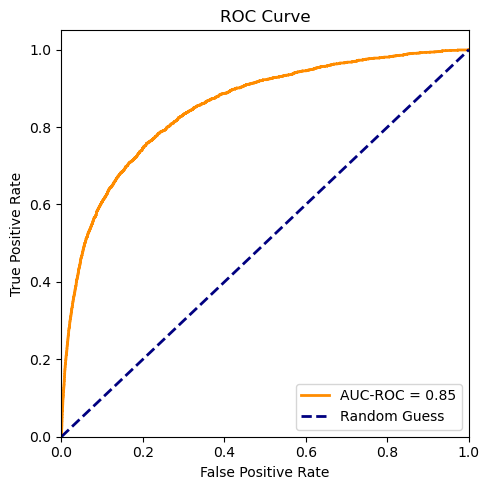

In [680]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plot_roc_auc(fpr, tpr, roc_auc)

Несмотря на то, что у модели получилась хорошая целевая метрика AUC-ROC = 0.8527, можно заметить, что precision для класса Default составляет всего 0.21. Это означает, что модели выгоднее предсказывать 0 класс (влияние дисбаланса классов).

In [361]:
def plot_precision_recall_curve(precision, recall, pr_auc):
    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, label=f'AUC-PR = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve ')
    plt.legend()
    plt.show()

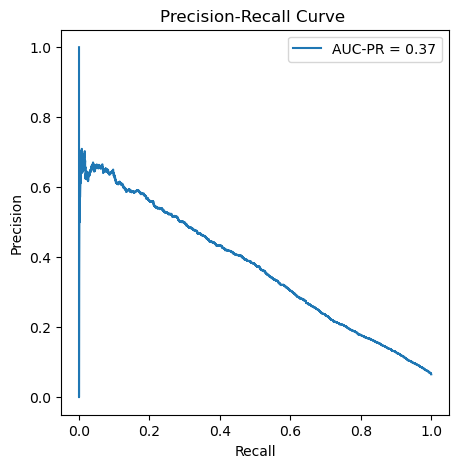

In [544]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision)

plot_precision_recall_curve(precision, recall, pr_auc)

Попробуем вручную задать веса классов, чтобы снизить влияние дисбаланса классов:

In [545]:
model_weighted_lr = LogisticRegression(
    class_weight={0: 1, 1: 5},  
    C=0.001, 
    penalty='l2', 
    solver='liblinear')

model_weighted_lr.fit(X_train_scaled, y_train)

y_test_pred_w_lr = model_weighted_lr.predict(X_test_scaled)
y_test_pred_proba_w_lr = model_weighted_lr.predict_proba(X_test_scaled)[:, 1]

print("\nФинальная оценка на тестовой выборке:\n")
print(classification_report(y_test, y_test_pred_w_lr, target_names=['Non-Default', 'Default']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_pred_proba_w_lr):.4f}")


Финальная оценка на тестовой выборке:

              precision    recall  f1-score   support

 Non-Default       0.96      0.95      0.96     39272
     Default       0.39      0.48      0.43      2762

    accuracy                           0.92     42034
   macro avg       0.68      0.71      0.69     42034
weighted avg       0.92      0.92      0.92     42034

AUC-ROC: 0.8524


Модель стала более точной (вырос precision)
- Теперь 39% предсказанных "дефолтов" действительно дефолты (было 21%).

Однако модель пропускает больше дефолтов (упал recall)
- Раньше ловила 74% дефолтов, теперь только 48%.

F1-score вырос (с 0.33 до 0.43)
- Улучшение баланса между precision и recall.

AUC-ROC практически не изменился

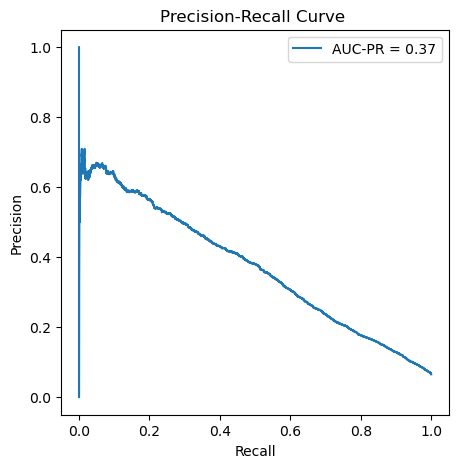

In [546]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba_w_lr)
pr_auc = auc(recall, precision)

plot_precision_recall_curve(precision, recall, pr_auc)

Полученные метрики:

| Class       | Precision | Recall | F1-Score |
|:-----------:|:---------:|:------:|:--------:|
| Non-Default | 0.96      | 0.95   | 0.96     |
| Default     | 0.39      | 0.48   | 0.43     |
     
- **AUC-ROC: 0.8524**

### Визуализация важности признаков

In [681]:
def plot_logreg_feature_importance(model, feature_names=None, 
                                 max_num_features=20, 
                                 figsize=(12, 8),
                                 title='Важность признаков в логистической регрессии'):
    
    # Получаем коэффициенты модели (берем первый класс для бинарной классификации)
    coef = model.coef_[0]
    
    if feature_names is None:
        if hasattr(model, 'feature_names_in_'):
            feature_names = model.feature_names_in_
        else:
            feature_names = [f'Признак {i}' for i in range(len(coef))]
    
    # Вычисляем важность как абсолютные значения коэффициентов
    importance = np.abs(coef)
    
    # Нормализуем важность
    normalized_importance = importance / importance.sum()
    
    # Сортируем признаки по важности
    sorted_idx = np.argsort(normalized_importance)[-max_num_features:]
    sorted_importance = normalized_importance[sorted_idx]
    sorted_names = np.array(feature_names)[sorted_idx]
    
    plt.figure(figsize=figsize)
    bars = plt.barh(range(len(sorted_idx)), 
                   sorted_importance, 
                   color='#87CEFA',
                   alpha=0.7)

    for i, (name, imp) in enumerate(zip(sorted_names, sorted_importance)):
        plt.text(imp + 0.005, i, 
                f'{imp:.3f}', 
                va='center',
                fontsize=10)
    
    plt.yticks(range(len(sorted_idx)), sorted_names)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Важность', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.xlim(0, min(1.0, max(normalized_importance) * 1.15))
    plt.tight_layout()

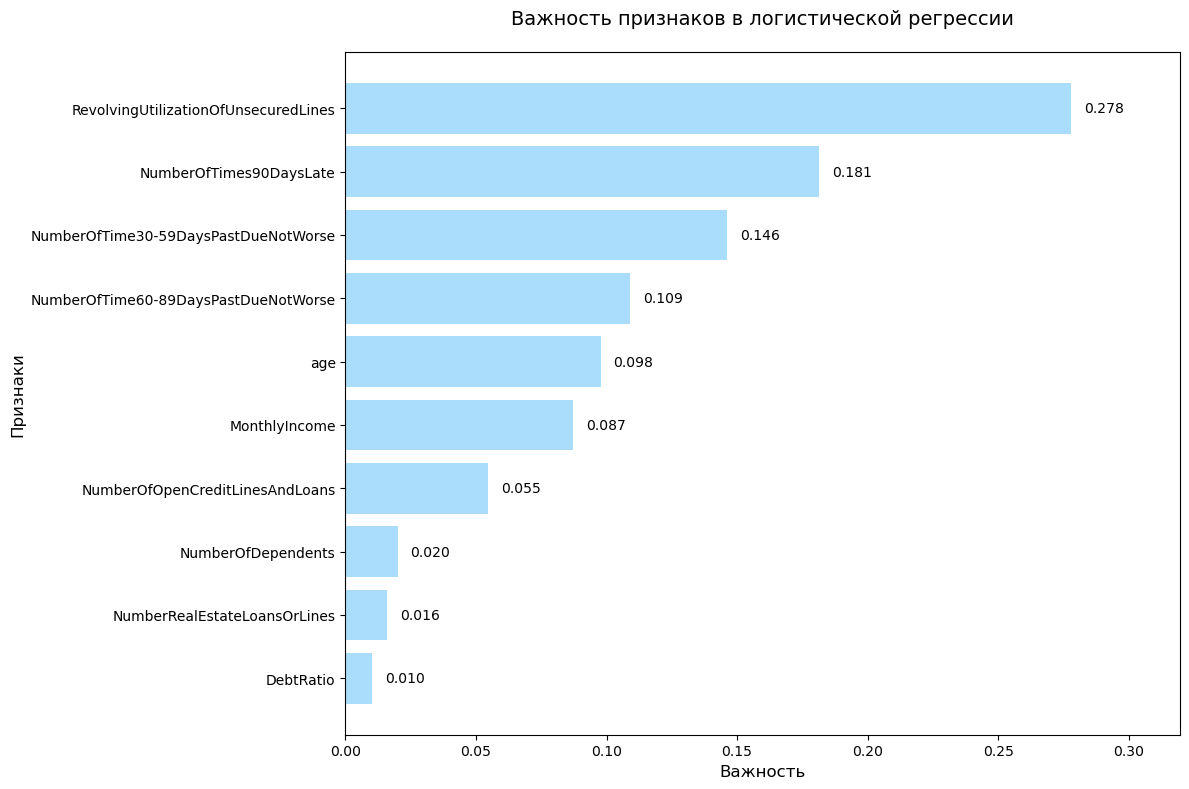

In [682]:
plot_logreg_feature_importance(model_weighted_lr,feature_names=list(X_train.columns))

## Модель XGBoost

### Проведем подбор оптимальных гиперпарматеров с помощью кросс-валидации (3 фолда)

In [661]:
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'seed': 42,
    'eval_metric':"auc",
    'scale_pos_weight': np.sum(y_train == 0) / np.sum(y_train == 1)  # Автобалансировка классов
}

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(**params_xgb),
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_xgb.fit(X_train_scaled, y_train)

best_model_xgb = grid_xgb.best_estimator_
print(f"Лучшие параметры: {grid_xgb.best_params_}")
print(f"Лучший AUC на валидации: {grid_xgb.best_score_:.4f}")

# Дотренировка на валидационных данных с ранней остановкой
best_model_xgb.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=0
)

y_test_proba_xgb = best_model_xgb.predict_proba(X_test_scaled)[:, 1]
y_test_pred_xgb = (y_test_proba >= 0.5).astype(int)

print("--------------------------------------------------------")

print("\nClassification Report (Train Set):")
print(classification_report(y_train, best_model_xgb.predict(X_train_scaled), target_names=['Non-Default', 'Default']))
print(f"\nTrain AUC-ROC: {roc_auc_score(y_train, best_model_xgb.predict_proba(X_train_scaled)[:, 1]):.4f}")

print("--------------------------------------------------------")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb, target_names=['Non-Default', 'Default']))

print(f"\nTest AUC-ROC: {roc_auc_score(y_test, y_test_proba_xgb):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred_xgb):.4f}")


Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
Лучший AUC на валидации: 0.8673
--------------------------------------------------------

Classification Report (Train Set):
              precision    recall  f1-score   support

 Non-Default       0.98      0.79      0.88     64143
     Default       0.21      0.80      0.34      4512

    accuracy                           0.79     68655
   macro avg       0.60      0.79      0.61     68655
weighted avg       0.93      0.79      0.84     68655


Train AUC-ROC: 0.8773
--------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

 Non-Default       0.98      0.73      0.84     39272
     Default       0.18      0.81      0.29      2762

    accuracy                           0.74     42034
   macro avg       0.58      0.77      0.56     42034
weighted avg       0.93      0.74     

Для того, чтобы проверить модель на наличие переобучения я вывела метрики как для тестовой, так и для обучающей выборки. Можно заметить, что на train AUC-ROC = 0.8773, а на test AUC-ROC = 0.8553 немного ниже, но эта разница не является критической. Поэтому можем утверждать, что модель не переобучилась.

### Итоговые метрики

Таким образом, с помощью модели XGBoost было получено схожее значение **AUC-ROC: 0.8553**.
Однако значениe F1-score снизилось:

| Class       | Precision | Recall | F1-Score |
|-------------|:---------:|:------:|:--------:|
| Non-Default | 0.98      | 0.80   | 0.88     | 
| Default     | 0.21      | 0.75   | 0.33     | 

### Визуализация важности признаков

In [407]:
def plot_feature_importance(model, feature_names=None, max_num_features=10, 
                          figsize=(10, 6), title='Важность признаков',importance_type='weight'):

    importance_dict = model.get_booster().get_score(importance_type=importance_type)
    
    # Определяем имена признаков
    if feature_names is None:
        if hasattr(model.get_booster(), 'feature_names'):
            feature_names = model.get_booster().feature_names
        else:
            feature_names = [f'f{i}' for i in range(len(importance_dict))]
    
    # Создаем словарь с именами признаков
    importance = {}
    for k, v in importance_dict.items():
        try:
            idx = int(k[1:]) 
            name = feature_names[idx] if idx < len(feature_names) else k
        except:
            name = k
        importance[name] = v
    
    # Нормализуем важность
    total = sum(importance.values())
    normalized_importance = {k: v/total for k, v in importance.items()}
    
    # Сортируем по важности
    sorted_items = sorted(normalized_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_items = sorted_items[:max_num_features] 
    
    features = [item[0] for item in sorted_items]
    importances = [item[1] for item in sorted_items]
    
    plt.figure(figsize=figsize)
    bars = plt.barh(range(len(features)), importances[::-1], color='#87CEFA')
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}',
                va='center', ha='left')
    
    plt.yticks(range(len(features)), features[::-1])
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Важность', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.xlim(0, min(1.0, max(importances) * 1.2))
    plt.tight_layout()
    plt.show()

In [408]:
booster = best_model_xgb.get_booster()
booster.feature_names = list(X_train.columns)

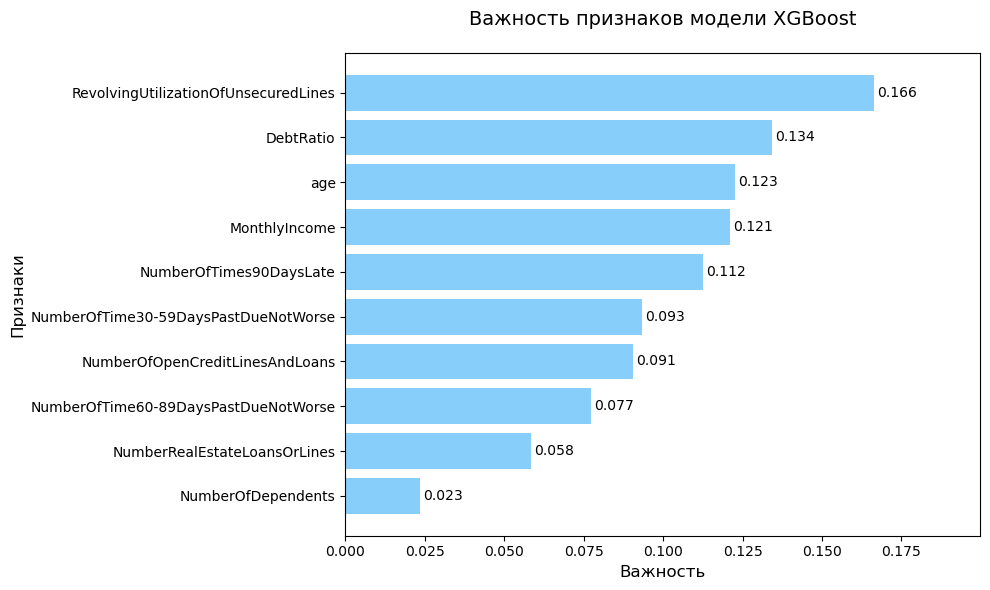

In [409]:
plot_feature_importance(best_model_xgb, title='Важность признаков модели XGBoost')

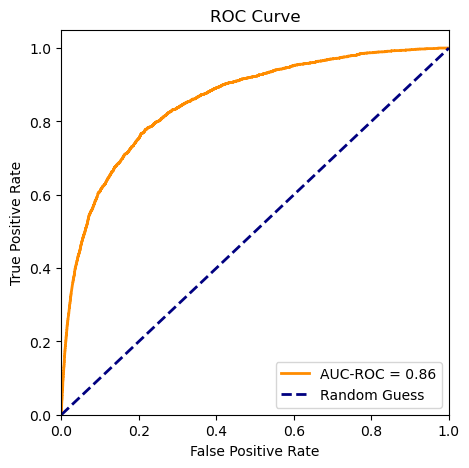

In [373]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_xgb)
roc_auc = auc(fpr, tpr)

plot_roc_auc(fpr, tpr, roc_auc)

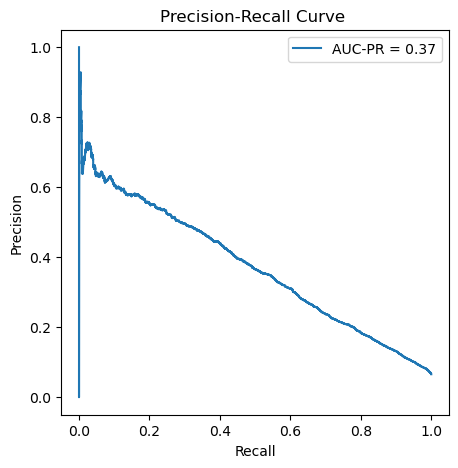

In [374]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba_xgb)
pr_auc = auc(recall, precision)

plot_precision_recall_curve(precision, recall, pr_auc)

# Модель CatBoost

### Проведем подбор оптимальных гиперпарматеров с помощью кросс-валидации (3 фолда)

In [433]:
params_cb = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'auto_class_weights': 'Balanced',  # Автобалансировка классов
    'early_stopping_rounds': 50,
    'verbose': 0
}

param_grid_cb = {
    'depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'min_child_samples': [1, 3]
}

# Создаем Pool для CatBoost (оптимизированный формат данных)
train_pool = Pool(X_train_scaled, y_train)
val_pool = Pool(X_val_scaled, y_val)

# GridSearch с CatBoost
grid_cb = GridSearchCV(
    estimator=CatBoostClassifier(**params),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

grid_cb.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

best_model_cb = grid_cb.best_estimator_
print(f"Лучшие параметры: {grid_cb.best_params_}")
print(f"Лучший AUC на валидации: {grid_cb.best_score_:.4f}")

# Дотренировка с ранней остановкой
best_model_cb.fit(
    X_train_scaled, y_train,
    eval_set=(X_val_scaled, y_val)
)

# Предсказания
y_test_proba_cb = best_model_cb.predict_proba(X_test_scaled)[:, 1]
y_test_pred_cb = best_model_cb.predict(X_test_scaled)

print("--------------------------------------------------------")

print("\nClassification Report (Train Set):")
print(classification_report(y_train, best_model_cb.predict(X_train_scaled), 
                          target_names=['Non-Default', 'Default']))
print(f"\nTrain AUC-ROC: {roc_auc_score(y_train, best_model_cb.predict_proba(X_train_scaled)[:, 1]):.4f}")

print("--------------------------------------------------------")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_cb, 
                          target_names=['Non-Default', 'Default']))
print(f"\nTest AUC-ROC: {roc_auc_score(y_test, y_test_proba_cb):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred_cb):.4f}")

TBB Warning: The number of workers is currently limited to 1. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 1. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Лучшие параметры: {'colsample_bylevel': 0.8, 'depth': 5, 'learning_rate': 0.01, 'min_child_samples': 1, 'subsample': 1.0}
Лучший AUC на валидации: 0.8678
--------------------------------------------------------

Classification Report (Train Set):
              precision    recall  f1-score   support

 Non-Default       0.98      0.73      0.84     64143
     Default       0.18      0.83      0.29      4512

    accuracy                           0.74     68655
   macro avg       0.58      0.78      0.56     68655
weighted avg       0.93      0.74      0.80     68655


Train AUC-ROC: 0.8623
--------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

 Non-Default       0.98      0.73      0.84     39272
     Default       0.18      0.81      0.29      2762

    accuracy                           0.74     42034
   macro avg       0.58      0.77      0.56     42034
weighted avg       0.93      0.74      

In [434]:
def plot_catboost_feature_importance(model, feature_names=None, max_num_features=10, 
                                   figsize=(10, 6), title='Важность признаков CatBoost',
                                   importance_type='PredictionValuesChange'):
    """
    Визуализация важности признаков для CatBoost (в долях от общей важности)
    
    Параметры:
    ----------
    model : CatBoost модель
    feature_names : list, optional
        Список имен признаков
    max_num_features : int, optional
        Максимальное количество отображаемых признаков
    figsize : tuple, optional
        Размер графика
    title : str, optional
        Заголовок графика
    importance_type : str, optional
        Тип важности ('PredictionValuesChange', 'LossFunctionChange', 'FeatureImportance')
    """
    importance = model.get_feature_importance(type=importance_type)
    
    # Нормализуем в доли от общей важности
    total_importance = sum(importance)
    importance_normalized = importance / total_importance

    if feature_names is None:
        feature_names = model.feature_names_
    
    # Создаем DataFrame для удобной сортировки
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_normalized
    }).sort_values('importance', ascending=False)
    
    # Берем топ-N признаков
    top_features = importance_df.head(max_num_features)
    
    top_features = top_features.sort_values('importance', ascending=True)
    
    plt.figure(figsize=figsize)
    bars = plt.barh(
        range(len(top_features)),
        top_features['importance'],
        color='#87CEFA'
    )
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(
            width + 0.001, 
            bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            va='center', 
            ha='left',
            fontsize=10
        )
    
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Доля важности', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.xlim(0, min(1.0, top_features['importance'].max() * 1.2))  # Максимум 100%
    plt.tight_layout()
    plt.show()

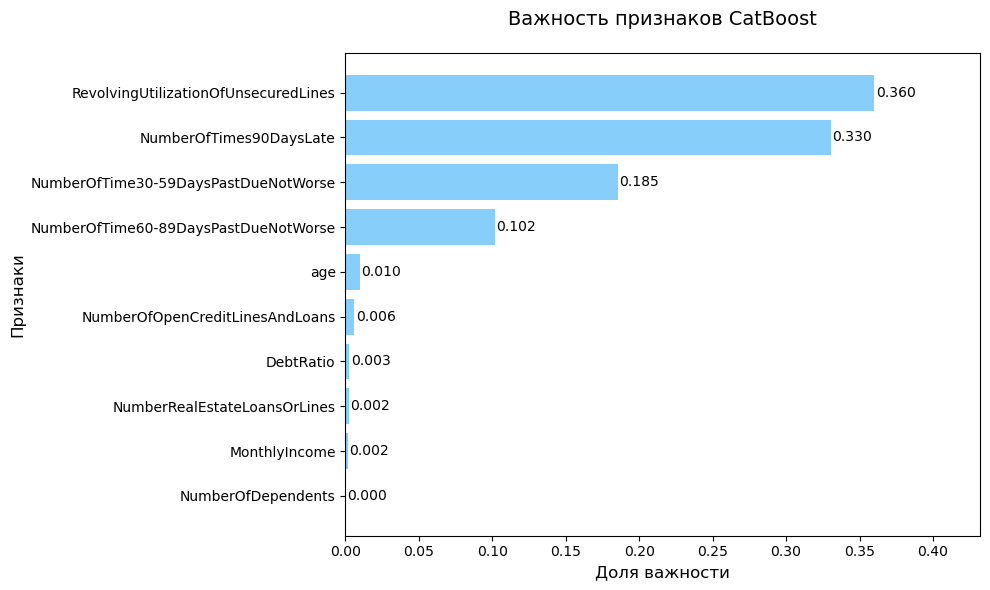

In [435]:
plot_catboost_feature_importance(best_model_cb, feature_names = X_train.columns)

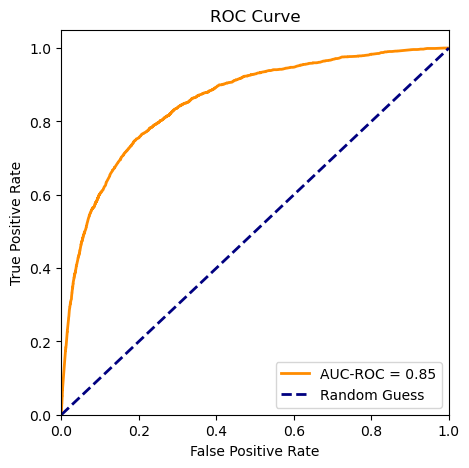

In [436]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_cb)
roc_auc = auc(fpr, tpr)

plot_roc_auc(fpr, tpr, roc_auc)

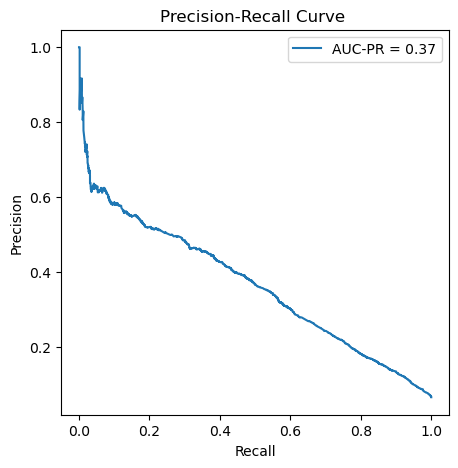

In [437]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba_cb)
pr_auc = auc(recall, precision)

plot_precision_recall_curve(precision, recall, pr_auc)

### Финальный выбор модели

Сравнивая метрики трех разных моделей: логистическая регрессия, XGBoost, CatBoost можем заметить, что ROC-AUC находится в очень близких диапазонах 0.8524, 0.8553 и 0.8547 соответственно. Однако метрика F1, которая является средним гармоническим precision и recall довольно сильно разнится между этими моделями. В лог регрессии - 0.43, в XGBoost - 0.33, в CatBoost - 0.29. Так как в датасете наблюдается сильный дисбаланс классов, нам важно, чтобы precision минорного класса (default) был как можно болеее высоким. По этому принципу лучше всего для задачи классификации заемщиков подходит модель логистической регресии.

Крайняя идея, которую я хотела бы попробовать в целях улучшения метрик - feature engeneering и увеличение минорного класса с помощью SMOTE. Так как лучше всего себя показала модель логистической регрессии, попробуем применить эти фичи к ней.

### feature engeneering

In [490]:
df = train_data_filtered.copy()

# Взаимодействие топ-3 признаков
df['Util_90Days'] = df['RevolvingUtilizationOfUnsecuredLines'] * df['NumberOfTimes90DaysLate']
df['Util_30-59Days'] = df['RevolvingUtilizationOfUnsecuredLines'] * df['NumberOfTime30-59DaysPastDueNotWorse']
df['Late_90_30-59'] = df['NumberOfTimes90DaysLate'] * df['NumberOfTime30-59DaysPastDueNotWorse']

# Логарифмирование
df['Log_Income'] = np.log1p(df['MonthlyIncome'])
df['Log_Utilization'] = np.log1p(df['RevolvingUtilizationOfUnsecuredLines'])

# Квадратичные термины
df['Age_sq'] = df['age'] ** 2
df['Utilization_sq'] = df['RevolvingUtilizationOfUnsecuredLines'] ** 2

# Суммарное количество просрочек
df['Total_Delinquencies'] = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] + 
    df['NumberOfTime60-89DaysPastDueNotWorse'] + 
    df['NumberOfTimes90DaysLate']
)

# Отношение просрочек к количеству кредитов
df['Delinquency_Ratio'] = df['Total_Delinquencies'] / (df['NumberOfOpenCreditLinesAndLoans'] + 1)

# Взаимодействие возраста с доходом
df['Age_Income'] = df['age'] * df['MonthlyIncome']

# Доход на иждивенца
df['Income_per_Dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)

# Отношение долга к доходу с учетом иждивенцев
df['Adjusted_DebtRatio'] = df['DebtRatio'] * (1 + df['NumberOfDependents']*0.1)

# Интенсивность просрочек (просрочки в год)
df['Delinquency_Rate'] = df['Total_Delinquencies'] / 2  # данные за 2 года

# Стабильность платежей (чем выше, тем хуже)
df['Payment_Instability'] = (
    df['NumberOfTime30-59DaysPastDueNotWorse'] * 1 +
    df['NumberOfTime60-89DaysPastDueNotWorse'] * 2 +
    df['NumberOfTimes90DaysLate'] * 3
)

In [491]:
X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df['SeriousDlqin2yrs']

X_train_val_new, X_test_new, y_train_val_new, y_test_new = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_val_new, y_train_val_new, test_size=0.3, random_state=42, stratify=y_train_val)

In [492]:
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_val_scaled_new = scaler.fit_transform(X_val_new)
X_test_scaled_new = scaler.transform(X_test_new)

In [495]:
param_grid_lr_fe = {
    'C': [0.001, 0.01, 0.1, 1],  
    'penalty': ['l1', 'l2'],               
    'solver': ['liblinear', 'saga']       
}

model_lr_fe = LogisticRegression(
    class_weight='balanced',  # учет дисбаланса
    random_state=42,
    max_iter=1000
)

grid_search_lr_fe = GridSearchCV(
    model_lr_fe, 
    param_grid_lr_fe, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_lr_fe.fit(X_train_scaled_new, y_train_new)

/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [496]:
best_model_lr_fe = grid_search_lr_fe.best_estimator_
print(f"Лучшие гиперпараметры: {grid_search_lr_fe.best_params_}")
print(f"Лучший AUC-ROC на валидации: {grid_search_lr_fe.best_score_:.4f}")

Лучшие гиперпараметры: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший AUC-ROC на валидации: 0.8620


In [497]:
# SMOTE + взвешенная регрессия
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Увеличиваем минорный класс до 30%
model = LogisticRegression(
    class_weight={0: 1, 1: 1},  # SMOTE уже балансирует
    C=0.001,
    penalty='l2',
    solver='liblinear'
)

pipeline = make_pipeline(smote, model)
pipeline.fit(X_train_scaled_new, y_train_new)

y_test_pred_new = pipeline.predict(X_test_scaled_new)
y_test_pred_proba_new = pipeline.predict_proba(X_test_scaled_new)[:, 1]

print("\nОценка на тренировочной выборке:")
print(classification_report(y_train_new, pipeline.predict(X_train_scaled_new), target_names=['Non-Default', 'Default']))
print(f"\nTrain AUC-ROC: {roc_auc_score(y_train_new, pipeline.predict_proba(X_train_scaled_new)[:, 1]):.4f}")

print("--------------------------------------------------------")

print("\nОценка на тестовой выборке:\n")
print(classification_report(y_test_new, y_test_pred_new, target_names=['Non-Default', 'Default']))
print(f"AUC-ROC: {roc_auc_score(y_test_new, y_test_pred_proba_new):.4f}")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f37de7aaa70>
Traceback (most recent call last):
  File "/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
  File "/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/pgurzhii/miniforge3/envs/boosting/lib/python3.10/site-packages/xgboost.libs/libgomp-25c89faf.


Оценка на тренировочной выборке:
              precision    recall  f1-score   support

 Non-Default       0.96      0.95      0.96     64143
     Default       0.40      0.47      0.44      4512

    accuracy                           0.92     68655
   macro avg       0.68      0.71      0.70     68655
weighted avg       0.93      0.92      0.92     68655


Train AUC-ROC: 0.8617
--------------------------------------------------------

Оценка на тестовой выборке:

              precision    recall  f1-score   support

 Non-Default       0.96      0.95      0.96     39272
     Default       0.40      0.46      0.43      2762

    accuracy                           0.92     42034
   macro avg       0.68      0.71      0.69     42034
weighted avg       0.92      0.92      0.92     42034

AUC-ROC: 0.8524


К сожалению, данный подход не дал прироста метрик. При увеличении минорного класса до 30% пропадает необходимость в ручном задании весов, однако метрики остаются на уровне изначальной модели логистической регресии

# ---------------------------------------------------------

# 3. Интерпретация и этика

### Отбор топ 5-признаков, влияюших на прогноз, с помощью shap

SHAP показывает, какой вклад каждый признак вносит в итоговое предсказание. Усредненные значения SHAP показывают глобальную важность признаков.

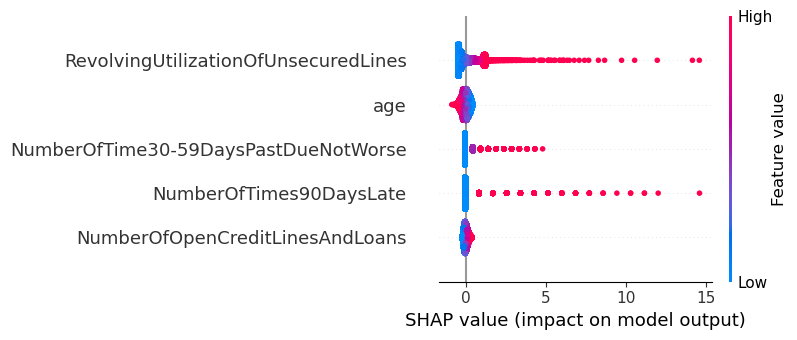

In [550]:
# Для логистической регрессии
explainer = shap.LinearExplainer(model_weighted_lr, X_train_scaled)
shap_values = explainer.shap_values(X_train_scaled)

# Визуализация топ-5 признаков
shap.summary_plot(shap_values, X_train_scaled, feature_names=X_train.columns, max_display=5)

**Описание графика:**

Ось X: SHAP value — сила и направление влияния признака на предсказание.
- Положительные значения - увеличивают вероятность дефолта (класс 1).
- Отрицательные значения - уменьшают вероятность дефолта.

Ось Y: Значения самого признака, где (на примере RevolvingUtilizationOfUnsecuderLines):
- Low (синие точки): Низкая кредитная нагрузка (близко к 0%).
- High (красные точки): Высокая кредитная нагрузка (близко к 100% или выше).

**Интерпретация графика:**
- С увеличением RevolvingUtilizationOfUnsecuderLines растет риск дефолта
- С увеличением возраста риск дефолта снижается (однако имеет не такой сильный вклад)
- При наличии и росте просрочек NumberOfTime30-59DaysPastDueNotWorse риск дефолта растет
- Просрочка NumberOfTimed90DaysLate также имеет прямую зависимость.
- С увеличением NumberOfOpenCreditLinesAndLoans также растет риск дефолта (но вклад незначительный)

### Отбор топ 5-признаков, влияюших на прогноз, с помощью lime

LIME используется для объяснения отдельных случаев (например, почему банк отказал конкретному клиенту). Рассмотрим для примера заемщика, принадлежащего к 1 классу (default) (idx=609)

In [551]:
X_test.iloc[609, :]

RevolvingUtilizationOfUnsecuredLines       1.000000
age                                       32.000000
NumberOfTime30-59DaysPastDueNotWorse       1.000000
DebtRatio                                  0.426611
MonthlyIncome                           1200.000000
NumberOfOpenCreditLinesAndLoans            3.000000
NumberOfTimes90DaysLate                    0.000000
NumberRealEstateLoansOrLines               0.000000
NumberOfTime60-89DaysPastDueNotWorse       0.000000
NumberOfDependents                         1.000000
Name: 81766, dtype: float64

In [552]:
y_test.iloc[609]

1

In [553]:
explainer = LimeTabularExplainer(
    X_train_scaled,
    feature_names=X_train.columns,
    class_names=['No Default', 'Default'],
    mode='classification'
)

# Пример для одного наблюдения
idx = 609
exp = explainer.explain_instance(X_test_scaled[idx], best_model.predict_proba)
exp.show_in_notebook(show_table=True)

## Оценка логичности влияния признаков

Оценим с помощью SHAP значений

In [628]:
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Impact': np.abs(shap_values).mean(0),
    'Direction': ['↑Risk' if coef > 0 else '↓Risk' 
                 for coef in best_model.coef_[0]]
}).sort_values('Impact', ascending=False)

print(shap_df)

                                Feature    Impact Direction
0  RevolvingUtilizationOfUnsecuredLines  0.507260     ↑Risk
1                                   age  0.183579     ↓Risk
2  NumberOfTime30-59DaysPastDueNotWorse  0.157200     ↑Risk
6               NumberOfTimes90DaysLate  0.109151     ↑Risk
5       NumberOfOpenCreditLinesAndLoans  0.100071     ↑Risk
8  NumberOfTime60-89DaysPastDueNotWorse  0.070163     ↑Risk
4                         MonthlyIncome  0.055622     ↓Risk
9                    NumberOfDependents  0.038544     ↑Risk
7          NumberRealEstateLoansOrLines  0.027687     ↑Risk
3                             DebtRatio  0.014770     ↓Risk


### Выводы по влиянию признаков:
- RevolvingUtilizationOfUnsecuredLines – Высокая кредитная нагрузка закономерно увеличивает риск дефолта, особенно при значениях >80%.

- age – Старший возраст снижает риск, но влияние на молодых клиентов требует проверки на дискриминацию (следующий шаг - оценка fairness модели).

- NumberOfTime30-59DaysPastDueNotWorse – Даже незначительные просрочки являются надежным индикатором будущих проблем.

- NumberOfTimes90DaysLate – Серьезные просрочки однозначно указывают на высокий риск дефолта.

- NumberOfOpenCreditLinesAndLoans – Множество кредитов может сигнализировать о перекредитованности, но требует дополнительного анализа.

Общий итог: Модель логична, но влияние возраста нуждается в дополнительном контроле.

### Оценка fairness модели

Fairness — это проверка, не дискриминирует ли модель определённые группы людей по чувствительным признакам (пол, возраст, раса и т.д.). Это необходимый пункт с точки зрения этики.

In [555]:
# Функция для расчета метрик
def calculate_fairness(y_true, y_pred, group):
    metrics = {}
    for g in set(group):
        idx = (group == g)
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()
        metrics[g] = {
            'FPR': fp / (fp + tn),  # False Positive Rate
            'TPR': tp / (tp + fn),  # True Positive Rate
            'Precision': tp / (tp + fp)
        }
    return metrics

**Разделение по возрасту**

In [606]:
X_test['age_group'] = np.where(X_test['age'] < 40, 'young', 'old')
groups_age = X_test['age_group']

y_pred_test = model_weighted_lr.predict(X_test_scaled)
fairness_metrics_age = calculate_fairness(y_test, y_pred_test, groups_age)

In [607]:
pd.DataFrame(fairness_metrics_age)

,young,old
FPR,0.096050,0.040106
TPR,0.558733,0.429052
Precision,0.406088,0.381356


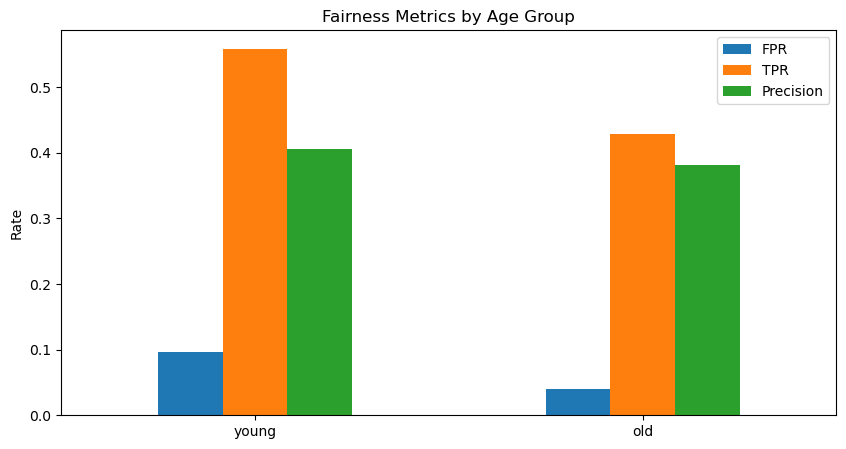

In [608]:
pd.DataFrame(fairness_metrics_age).T.plot(kind='bar', figsize=(10, 5))
plt.title('Fairness Metrics by Age Group')
plt.ylabel('Rate')
plt.xticks(rotation=0)
plt.show()

1. FPR. Модель чаще ошибочно классифицирует отрицательные примеры как положительные для молодых (в 2.4 раза выше FPR). Это может означать, что молодые необоснованно чаще подвергаются негативным последствиям.

2. TPR. Модель хуже распознает истинно положительные случаи для пожилых (разница ~13%). Это может привести к тому, что пожилые реже получат необходимые услуги.

3. Precision. Небольшое преимущество у молодых, но разница менее значима (всего ~2.5%). Это говорит, что среди положительных прогнозов для пожилых чуть больше ошибок.

**Проверим статистическую значимость разницы FPR в двух возрастных группах:**

Z-test p-value: 0.00


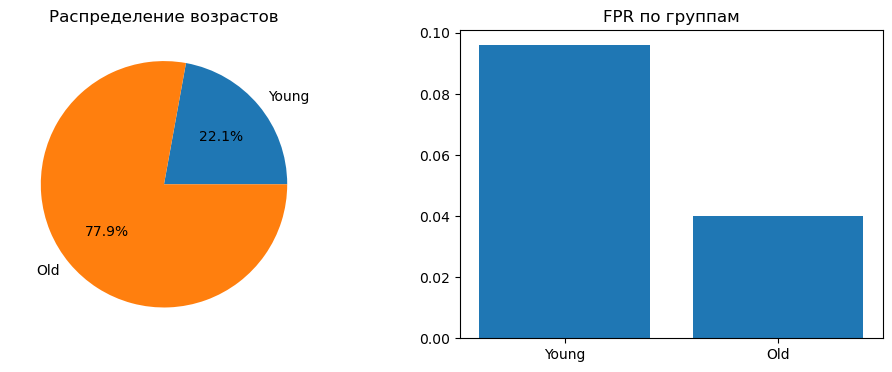

In [580]:
n_young = 9308  # всего young
fp_young = 0.096050*n_young   # FP = FPR * N_young
n_old = 32726
fp_old = 0.040106*32726

# Проверка значимости различий FPR (Z-test)
p_pool = (fp_young + fp_old) / (n_young + n_old)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_young + 1/n_old))
z = (fp_young/n_young - fp_old/n_old) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z)))
print(f"Z-test p-value: {p_value:.2f}")  # p < 0.05 → значимо

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].pie([n_young, n_old], labels=['Young', 'Old'], autopct='%1.1f%%')
ax[0].set_title('Распределение возрастов')
ax[1].bar(['Young', 'Old'], [fp_young/n_young, fp_old/n_old])
ax[1].set_title('FPR по группам')
plt.show()

Так как p-value < 0.05 различия в FPR между группами статистически значимые. 
Одним из способов борьбы с дискриминацией по возрасту является постобработка с помощью оптимизация порога классификации ThresholdOptimizer:

In [583]:
X_train['age_group'] = np.where(X_train['age'] < 40, 'young', 'old')

postprocessor = ThresholdOptimizer(estimator=model_weighted_lr, constraints="demographic_parity")  
postprocessor.fit(X_train_scaled, y_train, sensitive_features=X_train['age_group'])  

ThresholdOptimizer(estimator=LogisticRegression(C=0.001,
                                                class_weight={0: 1, 1: 5},
                                                solver='liblinear'))

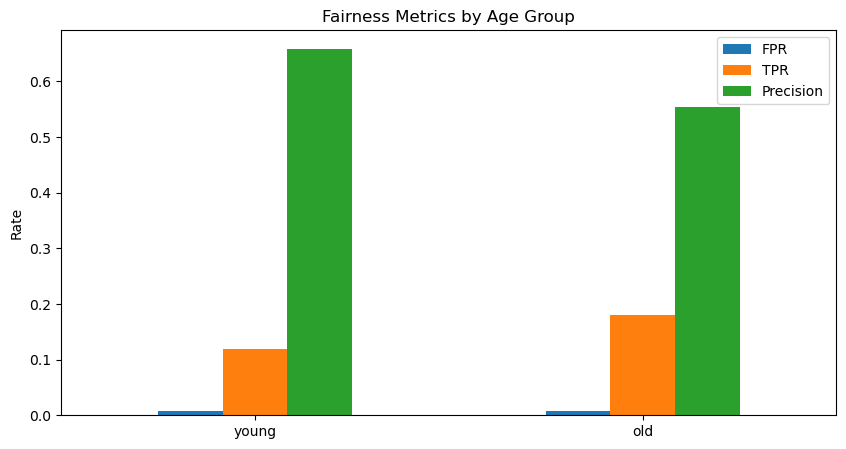

In [584]:
y_pred_test_fair = postprocessor.predict(X_test_scaled, sensitive_features=X_test['age_group'])
fairness_metrics_age_fair = calculate_fairness(y_test, y_pred_test_fair, groups_age)

pd.DataFrame(fairness_metrics_age_fair).T.plot(kind='bar', figsize=(10, 5))
plt.title('Fairness Metrics by Age Group')
plt.ylabel('Rate')
plt.xticks(rotation=0)
plt.show()

In [585]:
pd.DataFrame(fairness_metrics_age_fair)

,young,old
FPR,0.007204,0.008370
TPR,0.118488,0.180595
Precision,0.659091,0.554217


С помощью постобработки получены следующие результаты:

- Различия в FPR между группами действительно стали незначительными (0.72% vs 0.84%).
- Однако различия в TPR и precision выросли. 

Для того, чтобы окончательно избавиться от дискриминации по полу можно попробовать применить алгоритмы, минимизирующие дискриминацию, из библиотиеки fairlearn

**Проверка риска дискриминации по доходу:**

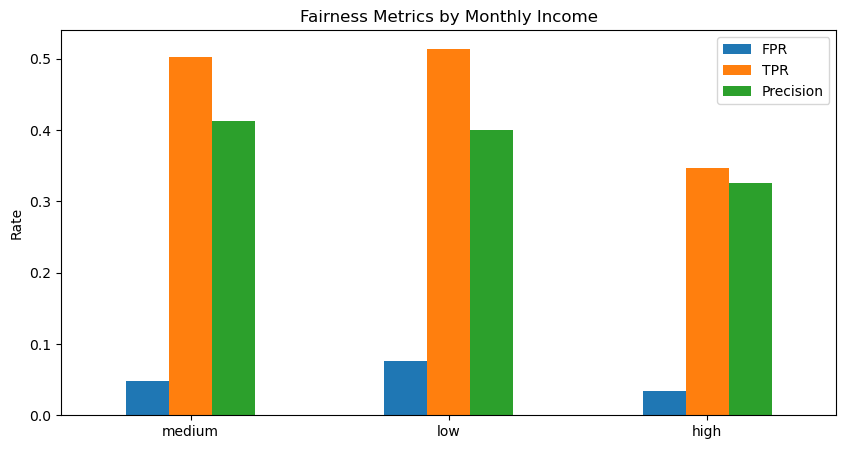

In [609]:
X_test['income_group'] = pd.qcut(
    X_test['MonthlyIncome'], 
    q=[0, 0.3, 0.7, 1], 
    labels=['low', 'medium', 'high']
)

groups_income = X_test['income_group']

y_pred_test = model_weighted_lr.predict(X_test_scaled)
fairness_metrics_income = calculate_fairness(y_test, y_pred_test, groups_income)

pd.DataFrame(fairness_metrics_income).T.plot(kind='bar', figsize=(10, 5))
plt.title('Fairness Metrics by Monthly Income')
plt.ylabel('Rate')
plt.xticks(rotation=0)
plt.show()

In [601]:
pd.DataFrame(fairness_metrics_income)

,medium,low,high
FPR,0.173691,0.265900,0.148981
TPR,0.730550,0.795936,0.638889
Precision,0.218316,0.227928,0.171642


Признаки дискриминации:
- Low-income группы страдают больше всего:
Самый высокий FPR (0.076) → чаще получают несправедливые отказы.
Несмотря на высокий TPR, их Precision ниже, чем у Medium.

- High-income группы тоже ущемляются, но иначе:
Низкий TPR (0.347) → их реальные запросы реже выполняются.
Низкий Precision (0.326) → среди одобренных решений много ошибок (возможно, модель слишком строга к ним).

- Medium-income:
Лучший баланс между FPR, TPR и Precision.

**Проверка риска дискриминации по прошлым проблемам:** 

Например клиенты с одной старой просрочкой могут получать отказы, даже если сейчас всё хорошо.

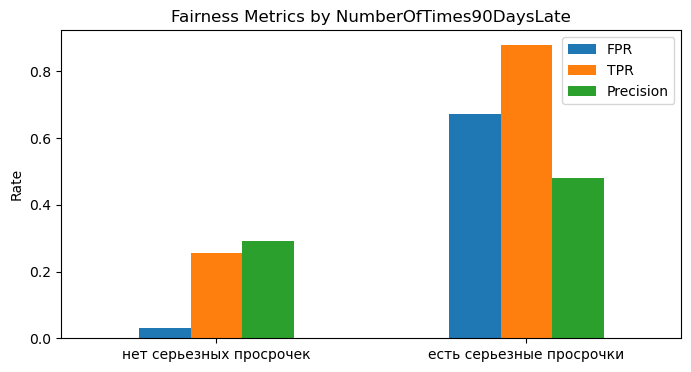

In [660]:
X_test['past_due_90_group'] = np.where(
    X_test['NumberOfTimes90DaysLate'] > 0,
    'есть серьезные просрочки',
    'нет серьезных просрочек'
)

groups_90 = X_test['past_due_90_group']
fairness_metrics_90 = calculate_fairness(y_test, y_pred_test, groups_90)
    
metrics_df_90 = pd.DataFrame(fairness_metrics_90).T
metrics_df_90[['FPR', 'TPR', 'Precision']].plot(kind='bar', figsize=(8, 4))
plt.title('Fairness Metrics by NumberOfTimes90DaysLate')
plt.ylabel('Rate')
plt.xticks(rotation=0)
plt.show()

In [611]:
pd.DataFrame(fairness_metrics_90)

,нет серьезных просрочек,есть серьезные просрочки
FPR,0.029601,0.671784
TPR,0.256138,0.879381
Precision,0.290323,0.481377


Группа с просрочками:
- Чрезмерно наказывается (FPR=67%) - большое количество несправедливых отказов.
- Высокий TPR (88%) - модель слишком жестко их проверяет.

Группа без просрочек:
- Низкий TPR (25%) - их реальные потребности часто игнорируются.
- Низкий Precision (29%) - среди одобренных заявок много ошибочных.

# 4. Выводы

### Качество модели:

- Лучшая модель: Логистическая регрессия с весами {0:1, 1:5} (AUC-ROC: 0.852, F1 для 1 класса (просроченная задолженность на 90 дней или более): 0.43).

- XGBoost/CatBoost показали схожий AUC-ROC (~0.855), но хуже баланс precision/recall.

- Основная проблема: низкий precision для дефолтов (0.33), что ведет к большому числу ложных отказов.

### Ограничения модели:

- Дисбаланс классов: Модель склонна к "перестраховке" (высокий FPR для групп с просрочками).

- Дискриминация:
Молодые получают больше несправедливых отказов (FPR в 2.4 раза выше, чем у пожилых).
Low-income группы чаще ошибочно классифицируются как дефолтные (FPR=26.6% vs 14.9% у high-income).

- Перекос в данных: Сильная зависимость от прошлых просрочек (например, FPR=67% для клиентов с просрочками).

### Рекомендации по улучшению

**Для данных:**
- Сбор дополнительных данных по заемщикам, относящимся к классу 1 (лица, имеющие просроченную задолженность на 90 дней или более).
- Сбор дополнительных данных по молодым заемщикам (<40 лет), чтобы снизить дисбаланс по критерию возраста в датасете.
- Сбор дополнительных признаков (например, кредитный рейтинг, история платежей за последние 6 месяцев)

**Для модели**
- Использовать Fairlearn (например, ThresholdOptimizer) для устранения дискриминации.
- Добавить кастомные веса для чувствительных групп (например, возраст <40 лет).

**Для интерпретации:**
- Мониторинг FPR/TPR для уязвимых групп (например, молодые, low-income) в продакшене.

### Пример интерпретации работы модели:

**Как изменится прогноз, если у заемщика появится иждивенец:**

NumberOfDependents (Impact: 0.039, ↑Risk)
Если у заемщика появится иждивенец, то его риск вырастет на +3.9%. В большой семье выше расходы, но признак слабо влияет на решение.

**Как изменится прогноз, если заемщик увеличит использование кредитных линий:**

RevolvingUtilizationOfUnsecuredLines (Impact: 0.507, ↑Risk)  
Если заемщик увеличивает использование кредитных линий, его риск вырастет на 50.7%. Это самый сильный фактор — высокая закредитованность резко ухудшает прогноз.  

**Как изменится прогноз, если у заемщика увеличится доход:**

MonthlyIncome (Impact: 0.056, ↓Risk)  
Рост дохода снижает риск на 5.6%, но эффект умеренный. Важен не абсолютный размер зарплаты, а соотношение с обязательствами.    

**Как изменится прогноз, если у заемщика появятся просрочки:**

NumberOfTime30-59DaysPastDueNotWorse (Impact: 0.157, ↑Risk)  
Каждый случай просрочки 30–59 дней увеличивает риск на +15.7%. Даже если ситуация не критична, частые задержки сигнализируют о проблемах.  